In [2]:
import sys
sys.path.append('../')

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from utils import PlotHelper
from tqdm import tqdm

In [3]:
# Device set-up

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps:0")
else:
    device = torch.device("cpu")
    
print(device)

cuda:0


# Load CIFAR10 dataset as primitive datasets
Only select four classes to use.

In [4]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ])

cifar_train_data = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
cifar_test_data = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)

cifar_train_data.targets = torch.tensor(cifar_train_data.targets)
cifar_test_data.targets = torch.tensor(cifar_test_data.targets)

100%|██████████| 170498071/170498071 [00:05<00:00, 31724557.96it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [5]:
cifar_train_data.data.shape

(50000, 32, 32, 3)

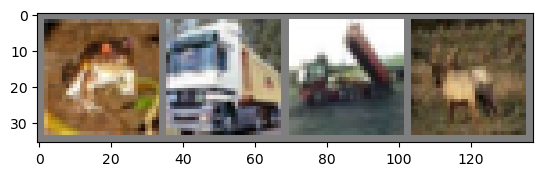

frog  truck truck deer 


In [6]:
# Plot some data to visualize

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
classes = ('plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
batch_size = 4
loader = DataLoader(cifar_train_data,batch_size=batch_size)
dataiter = iter(loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
# Select four classes and generate train/test primitive datasets
n_cifar_class = 4
prim_class_names = [classes[i] for i in range(n_cifar_class)]


train_filter = cifar_train_data.targets < 0
for i in range(n_cifar_class):
    train_filter = train_filter | (cifar_train_data.targets==i)
cifar_train_data.data, cifar_train_data.targets = cifar_train_data.data[train_filter], cifar_train_data.targets[train_filter]

test_filter = cifar_test_data.targets < 0
for i in range(n_cifar_class):
    test_filter = test_filter | (cifar_test_data.targets==i)
cifar_test_data.data, cifar_test_data.targets = cifar_test_data.data[test_filter], cifar_test_data.targets[test_filter]

cifar_datasets = {
    "train": cifar_train_data,
    "test": cifar_test_data,
}

In [8]:
cifar_train_kwargs = {'batch_size': 256}
cifar_train_loader = DataLoader(cifar_train_data, **cifar_train_kwargs)

cifar_test_kwargs = {'batch_size': 256}
cifar_test_loader = DataLoader(cifar_test_data, **cifar_test_kwargs)

## Train a classifier using direct supervision
Test the dataset and the neural network models by running a classic training pipeline using direct supervison. (This part can be skipped)

In [9]:
from utils import plot_confusion_matrix, prim_test, prim_train, PlotHelper

In [10]:
class Net(nn.Module):
    def __init__(self, N=0):
        super().__init__()
        self.n_class = N
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, N)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch: 0
Accuracy of the network on the test data: 59 %
Accuracy of activity  0 : 63 %
Accuracy of activity  1 : 86 %
Accuracy of activity  2 : 19 %
Accuracy of activity  3 : 68 %
Epoch: 1
Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 69 %
Accuracy of activity  1 : 88 %
Accuracy of activity  2 : 45 %
Accuracy of activity  3 : 76 %
Epoch: 2
Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 74 %
Accuracy of activity  1 : 93 %
Accuracy of activity  2 : 47 %
Accuracy of activity  3 : 72 %
Epoch: 3
Accuracy of the network on the test data: 73 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 88 %
Accuracy of activity  2 : 52 %
Accuracy of activity  3 : 81 %
Epoch: 4
Accuracy of the network on the test data: 74 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 90 %
Accuracy of activity  2 : 55 %
Accuracy of activity  3 : 81 %
Epoch: 5
Accuracy of the network on the test data: 75 %
Accuracy of activity  0 : 73 %
Accuracy of a

/home/nesl/Documents/PYLON-CE-examples/CE-image-examples/../utils.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


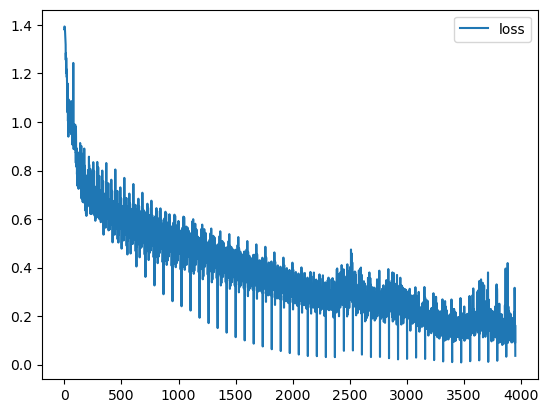

In [11]:
model = Net(n_cifar_class)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
prim_train(model, cifar_train_loader,cifar_test_loader, optimizer, 50, device=device)

Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 62 %
Accuracy of activity  1 : 69 %
Accuracy of activity  2 : 86 %
Accuracy of activity  3 : 59 %


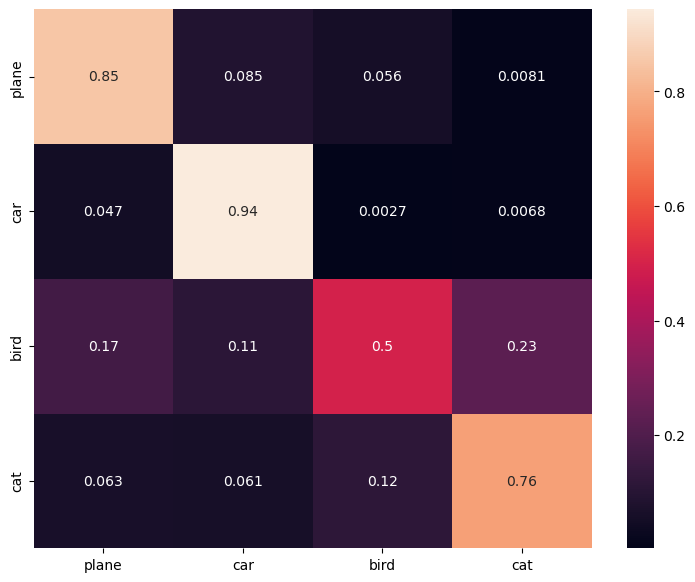

In [12]:
y_true, y_pred, _ = prim_test(model, cifar_test_loader)
plot_confusion_matrix(y_true, y_pred, prim_class_names)

# Supervise image classifier w/ complex event labels using PYLON
In this part, we will first generate a complex event dataset according to predifined FSM rules, and then define PYLON constraints for trianing using distant (high-level) complex event label.

We define three complex event classes:
> $e_0$: Image 1 occurs before 3.  
$e_1$: Image 0 occurs before 2.  
$e_2$: Any event that does not satisify previous event patterns.

Corresponding FSMs are defined in `fsm.py`. To see details of the complex event dataset, check `complex_pattern` function in `image_data.py`.

## Generate complex event dataset for PYLON training


In [13]:
# Generate complex event training/test set using prmitive dataset
from fsm import Event0, Event1
from img_data import complex_pattern

fsm_list = [Event0(), Event1()]
event_class_names = ["Event 0", "Event 1", "No events"]
n_event_class = len(fsm_list) + 1

arity = 3
event_train_data = complex_pattern(n=arity, dataset="train", prim_datasets=cifar_datasets, fsm_list=fsm_list, seed=0)
event_test_data = complex_pattern(n=arity, dataset="test", prim_datasets=cifar_datasets, fsm_list=fsm_list, seed=0)

100%|██████████| 9912422/9912422 [00:00<00:00, 74172142.87it/s]


Extracting /home/nesl/Documents/PYLON-CE-examples/CE-image-examples/MNIST/raw/train-images-idx3-ubyte.gz to /home/nesl/Documents/PYLON-CE-examples/CE-image-examples/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40813913.01it/s]

Extracting /home/nesl/Documents/PYLON-CE-examples/CE-image-examples/MNIST/raw/train-labels-idx1-ubyte.gz to /home/nesl/Documents/PYLON-CE-examples/CE-image-examples/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 72822619.98it/s]


Extracting /home/nesl/Documents/PYLON-CE-examples/CE-image-examples/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/nesl/Documents/PYLON-CE-examples/CE-image-examples/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 28777233.79it/s]


Extracting /home/nesl/Documents/PYLON-CE-examples/CE-image-examples/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/nesl/Documents/PYLON-CE-examples/CE-image-examples/MNIST/raw



In [14]:
event_train_kwargs = {'batch_size': 64}
event_train_loader = DataLoader(event_train_data, **event_train_kwargs)

# Used to test correctness of predicted event labels
event_test_kwargs = {'batch_size': 64}
event_test_loader = DataLoader(event_test_data, **event_test_kwargs)

## Define PYLON constraints for complex events
We use the previous FSMs as constraints

In [15]:
from pylon.constraint import constraint

def enforce_pattern(*logits_sequence, **kwargs):
    '''
    logits_sequence: a sequence of logits tensors returned by the primitive classifier
    kwargs['event_label']: ground truth complex event label
    kwargs['event_fsm']: a list of finite state machines for corresponding complex event class
    kwargs['n_event_class]: the number of complex event classes
    '''
    pred_labels = []
    logits_sequence_batch = torch.stack(logits_sequence,-1)
    
    for seq in logits_sequence_batch: # process the batch sequentially
        pred_label = kwargs['n_event_class'] - 1
        for fsm in kwargs['event_fsm']:
            if fsm.check(seq) == True: # (torch,torch,torch) == (int,int,int) in pylon constraints
                pred_label = fsm.label
        pred_labels.append(torch.tensor(pred_label))
    
    pred_labels = torch.stack(pred_labels)

    return pred_labels == kwargs['event_label']

enfore_pattern_cons = constraint(enforce_pattern)

## Training and Evaluation

In [16]:
def pylon_train(model, n_epoch, optimizer, n_print=10):
    plot_loss = PlotHelper()
    for epoch in range(n_epoch):
        print("Epoch: ", epoch)
        # train
        for i, batch in enumerate(tqdm(event_train_loader)):
            model.train()
            optimizer.zero_grad()
            # print(len(x_event_train))
            img1, img2, img3, label = batch
        
            output1 = model(img1)
            output2 = model(img2)
            output3 = model(img3)
            
            pred1 = output1.argmax(dim=1, keepdim=False)
            pred2 = output2.argmax(dim=1, keepdim=False)
            pred3 = output3.argmax(dim=1, keepdim=False)
            # print("o",output1)
            
            closs = enfore_pattern_cons(output1, output2, output3, event_label=label, event_fsm=fsm_list, n_event_class=n_event_class)
            dampner = closs.detach()
            plot_loss.add(closs = dampner)

            closs.backward()
            optimizer.step()
            
            if i % n_print == 0 and i != 0:
                prim_test(model, cifar_test_loader)

    plot_loss.show()
    prim_test(model, cifar_test_loader)

Epoch:  0


  0%|          | 0/105 [00:00<?, ?it/s]/home/nesl/Documents/PYLON-CE-examples/CE-image-examples/../pylon/brute_force_solver.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.tensor(data=self.cond(*sample,**kwargs), dtype=torch.bool) for sample in samples ])
 11%|█▏        | 12/105 [00:01<00:16,  5.70it/s]

Accuracy of the network on the test data: 32 %
Accuracy of activity  0 : 63 %
Accuracy of activity  1 : 65 %
Accuracy of activity  2 :  0 %
Accuracy of activity  3 :  0 %


 21%|██        | 22/105 [00:03<00:14,  5.67it/s]

Accuracy of the network on the test data: 34 %
Accuracy of activity  0 : 58 %
Accuracy of activity  1 : 78 %
Accuracy of activity  2 :  0 %
Accuracy of activity  3 :  0 %


 30%|███       | 32/105 [00:04<00:12,  5.63it/s]

Accuracy of the network on the test data: 42 %
Accuracy of activity  0 : 47 %
Accuracy of activity  1 : 57 %
Accuracy of activity  2 : 56 %
Accuracy of activity  3 :  6 %


 40%|████      | 42/105 [00:06<00:11,  5.68it/s]

Accuracy of the network on the test data: 45 %
Accuracy of activity  0 : 46 %
Accuracy of activity  1 : 74 %
Accuracy of activity  2 : 40 %
Accuracy of activity  3 : 17 %


 50%|████▉     | 52/105 [00:07<00:09,  5.54it/s]

Accuracy of the network on the test data: 46 %
Accuracy of activity  0 : 70 %
Accuracy of activity  1 : 28 %
Accuracy of activity  2 : 66 %
Accuracy of activity  3 : 22 %


 59%|█████▉    | 62/105 [00:09<00:07,  5.50it/s]

Accuracy of the network on the test data: 51 %
Accuracy of activity  0 : 60 %
Accuracy of activity  1 : 66 %
Accuracy of activity  2 : 17 %
Accuracy of activity  3 : 63 %


 69%|██████▊   | 72/105 [00:10<00:06,  5.41it/s]

Accuracy of the network on the test data: 51 %
Accuracy of activity  0 : 48 %
Accuracy of activity  1 : 73 %
Accuracy of activity  2 : 25 %
Accuracy of activity  3 : 59 %


 78%|███████▊  | 82/105 [00:12<00:04,  5.25it/s]

Accuracy of the network on the test data: 54 %
Accuracy of activity  0 : 61 %
Accuracy of activity  1 : 66 %
Accuracy of activity  2 : 48 %
Accuracy of activity  3 : 42 %


 88%|████████▊ | 92/105 [00:14<00:02,  5.48it/s]

Accuracy of the network on the test data: 51 %
Accuracy of activity  0 : 55 %
Accuracy of activity  1 : 60 %
Accuracy of activity  2 :  2 %
Accuracy of activity  3 : 88 %


 97%|█████████▋| 102/105 [00:15<00:00,  5.69it/s]

Accuracy of the network on the test data: 53 %
Accuracy of activity  0 : 65 %
Accuracy of activity  1 : 77 %
Accuracy of activity  2 : 43 %
Accuracy of activity  3 : 28 %


100%|██████████| 105/105 [00:15<00:00,  6.66it/s]


Epoch:  1


 11%|█▏        | 12/105 [00:01<00:16,  5.76it/s]

Accuracy of the network on the test data: 57 %
Accuracy of activity  0 : 60 %
Accuracy of activity  1 : 75 %
Accuracy of activity  2 : 42 %
Accuracy of activity  3 : 52 %


 21%|██        | 22/105 [00:03<00:14,  5.59it/s]

Accuracy of the network on the test data: 55 %
Accuracy of activity  0 : 44 %
Accuracy of activity  1 : 83 %
Accuracy of activity  2 : 17 %
Accuracy of activity  3 : 75 %


 30%|███       | 32/105 [00:04<00:13,  5.58it/s]

Accuracy of the network on the test data: 58 %
Accuracy of activity  0 : 57 %
Accuracy of activity  1 : 81 %
Accuracy of activity  2 : 57 %
Accuracy of activity  3 : 35 %


 40%|████      | 42/105 [00:06<00:11,  5.49it/s]

Accuracy of the network on the test data: 59 %
Accuracy of activity  0 : 57 %
Accuracy of activity  1 : 75 %
Accuracy of activity  2 : 54 %
Accuracy of activity  3 : 49 %


 50%|████▉     | 52/105 [00:07<00:09,  5.63it/s]

Accuracy of the network on the test data: 59 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 72 %
Accuracy of activity  2 : 38 %
Accuracy of activity  3 : 58 %


 59%|█████▉    | 62/105 [00:09<00:07,  5.54it/s]

Accuracy of the network on the test data: 60 %
Accuracy of activity  0 : 59 %
Accuracy of activity  1 : 83 %
Accuracy of activity  2 : 69 %
Accuracy of activity  3 : 30 %


 69%|██████▊   | 72/105 [00:10<00:05,  5.73it/s]

Accuracy of the network on the test data: 58 %
Accuracy of activity  0 : 41 %
Accuracy of activity  1 : 81 %
Accuracy of activity  2 : 33 %
Accuracy of activity  3 : 77 %


 78%|███████▊  | 82/105 [00:12<00:04,  5.63it/s]

Accuracy of the network on the test data: 62 %
Accuracy of activity  0 : 69 %
Accuracy of activity  1 : 75 %
Accuracy of activity  2 : 62 %
Accuracy of activity  3 : 44 %


 88%|████████▊ | 92/105 [00:13<00:02,  5.55it/s]

Accuracy of the network on the test data: 60 %
Accuracy of activity  0 : 64 %
Accuracy of activity  1 : 72 %
Accuracy of activity  2 : 17 %
Accuracy of activity  3 : 86 %


 97%|█████████▋| 102/105 [00:15<00:00,  5.56it/s]

Accuracy of the network on the test data: 63 %
Accuracy of activity  0 : 66 %
Accuracy of activity  1 : 85 %
Accuracy of activity  2 : 43 %
Accuracy of activity  3 : 61 %


100%|██████████| 105/105 [00:15<00:00,  6.78it/s]


Epoch:  2


 11%|█▏        | 12/105 [00:01<00:16,  5.79it/s]

Accuracy of the network on the test data: 65 %
Accuracy of activity  0 : 58 %
Accuracy of activity  1 : 83 %
Accuracy of activity  2 : 62 %
Accuracy of activity  3 : 58 %


 21%|██        | 22/105 [00:03<00:14,  5.70it/s]

Accuracy of the network on the test data: 65 %
Accuracy of activity  0 : 63 %
Accuracy of activity  1 : 82 %
Accuracy of activity  2 : 39 %
Accuracy of activity  3 : 77 %


 30%|███       | 32/105 [00:04<00:13,  5.35it/s]

Accuracy of the network on the test data: 65 %
Accuracy of activity  0 : 56 %
Accuracy of activity  1 : 89 %
Accuracy of activity  2 : 61 %
Accuracy of activity  3 : 56 %


 40%|████      | 42/105 [00:06<00:11,  5.48it/s]

Accuracy of the network on the test data: 65 %
Accuracy of activity  0 : 62 %
Accuracy of activity  1 : 76 %
Accuracy of activity  2 : 64 %
Accuracy of activity  3 : 57 %


 50%|████▉     | 52/105 [00:07<00:09,  5.63it/s]

Accuracy of the network on the test data: 65 %
Accuracy of activity  0 : 72 %
Accuracy of activity  1 : 79 %
Accuracy of activity  2 : 61 %
Accuracy of activity  3 : 50 %


 59%|█████▉    | 62/105 [00:09<00:07,  5.70it/s]

Accuracy of the network on the test data: 65 %
Accuracy of activity  0 : 54 %
Accuracy of activity  1 : 87 %
Accuracy of activity  2 : 75 %
Accuracy of activity  3 : 45 %


 69%|██████▊   | 72/105 [00:10<00:05,  5.71it/s]

Accuracy of the network on the test data: 63 %
Accuracy of activity  0 : 57 %
Accuracy of activity  1 : 85 %
Accuracy of activity  2 : 25 %
Accuracy of activity  3 : 87 %


 78%|███████▊  | 82/105 [00:12<00:04,  5.63it/s]

Accuracy of the network on the test data: 67 %
Accuracy of activity  0 : 70 %
Accuracy of activity  1 : 79 %
Accuracy of activity  2 : 66 %
Accuracy of activity  3 : 53 %


 88%|████████▊ | 92/105 [00:13<00:02,  5.75it/s]

Accuracy of the network on the test data: 63 %
Accuracy of activity  0 : 63 %
Accuracy of activity  1 : 68 %
Accuracy of activity  2 : 37 %
Accuracy of activity  3 : 85 %


 97%|█████████▋| 102/105 [00:15<00:00,  5.78it/s]

Accuracy of the network on the test data: 68 %
Accuracy of activity  0 : 68 %
Accuracy of activity  1 : 88 %
Accuracy of activity  2 : 48 %
Accuracy of activity  3 : 67 %


100%|██████████| 105/105 [00:15<00:00,  6.84it/s]


Epoch:  3


 11%|█▏        | 12/105 [00:01<00:16,  5.76it/s]

Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 65 %
Accuracy of activity  1 : 84 %
Accuracy of activity  2 : 64 %
Accuracy of activity  3 : 64 %


 21%|██        | 22/105 [00:03<00:15,  5.46it/s]

Accuracy of the network on the test data: 67 %
Accuracy of activity  0 : 68 %
Accuracy of activity  1 : 75 %
Accuracy of activity  2 : 49 %
Accuracy of activity  3 : 78 %


 30%|███       | 32/105 [00:04<00:12,  5.78it/s]

Accuracy of the network on the test data: 68 %
Accuracy of activity  0 : 56 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 59 %
Accuracy of activity  3 : 67 %


 40%|████      | 42/105 [00:06<00:12,  5.20it/s]

Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 67 %
Accuracy of activity  1 : 83 %
Accuracy of activity  2 : 64 %
Accuracy of activity  3 : 60 %


 50%|████▉     | 52/105 [00:07<00:09,  5.50it/s]

Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 72 %
Accuracy of activity  1 : 78 %
Accuracy of activity  2 : 65 %
Accuracy of activity  3 : 59 %


 59%|█████▉    | 62/105 [00:09<00:07,  5.63it/s]

Accuracy of the network on the test data: 68 %
Accuracy of activity  0 : 57 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 67 %
Accuracy of activity  3 : 59 %


 69%|██████▊   | 72/105 [00:10<00:05,  5.71it/s]

Accuracy of the network on the test data: 66 %
Accuracy of activity  0 : 59 %
Accuracy of activity  1 : 87 %
Accuracy of activity  2 : 34 %
Accuracy of activity  3 : 85 %


 78%|███████▊  | 82/105 [00:12<00:03,  5.76it/s]

Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 80 %
Accuracy of activity  2 : 69 %
Accuracy of activity  3 : 55 %


 88%|████████▊ | 92/105 [00:13<00:02,  5.70it/s]

Accuracy of the network on the test data: 65 %
Accuracy of activity  0 : 67 %
Accuracy of activity  1 : 68 %
Accuracy of activity  2 : 40 %
Accuracy of activity  3 : 85 %


 97%|█████████▋| 102/105 [00:15<00:00,  5.54it/s]

Accuracy of the network on the test data: 68 %
Accuracy of activity  0 : 65 %
Accuracy of activity  1 : 90 %
Accuracy of activity  2 : 55 %
Accuracy of activity  3 : 62 %


100%|██████████| 105/105 [00:15<00:00,  6.72it/s]


Epoch:  4


 11%|█▏        | 12/105 [00:01<00:16,  5.80it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 69 %
Accuracy of activity  1 : 82 %
Accuracy of activity  2 : 64 %
Accuracy of activity  3 : 68 %


 21%|██        | 22/105 [00:03<00:14,  5.56it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 70 %
Accuracy of activity  1 : 80 %
Accuracy of activity  2 : 50 %
Accuracy of activity  3 : 80 %


 30%|███       | 32/105 [00:04<00:12,  5.73it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 60 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 57 %
Accuracy of activity  3 : 72 %


 40%|████      | 42/105 [00:06<00:10,  5.75it/s]

Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 67 %
Accuracy of activity  1 : 83 %
Accuracy of activity  2 : 69 %
Accuracy of activity  3 : 58 %


 50%|████▉     | 52/105 [00:07<00:09,  5.71it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 74 %
Accuracy of activity  1 : 81 %
Accuracy of activity  2 : 64 %
Accuracy of activity  3 : 61 %


 59%|█████▉    | 62/105 [00:09<00:07,  5.66it/s]

Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 57 %
Accuracy of activity  1 : 94 %
Accuracy of activity  2 : 58 %
Accuracy of activity  3 : 67 %


 69%|██████▊   | 72/105 [00:10<00:05,  5.67it/s]

Accuracy of the network on the test data: 67 %
Accuracy of activity  0 : 57 %
Accuracy of activity  1 : 80 %
Accuracy of activity  2 : 48 %
Accuracy of activity  3 : 85 %


 78%|███████▊  | 82/105 [00:12<00:04,  5.71it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 73 %
Accuracy of activity  1 : 82 %
Accuracy of activity  2 : 69 %
Accuracy of activity  3 : 58 %


 88%|████████▊ | 92/105 [00:13<00:02,  5.65it/s]

Accuracy of the network on the test data: 66 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 70 %
Accuracy of activity  2 : 38 %
Accuracy of activity  3 : 87 %


 97%|█████████▋| 102/105 [00:15<00:00,  5.68it/s]

Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 64 %
Accuracy of activity  1 : 92 %
Accuracy of activity  2 : 61 %
Accuracy of activity  3 : 59 %


100%|██████████| 105/105 [00:15<00:00,  6.85it/s]


Epoch:  5


 11%|█▏        | 12/105 [00:01<00:16,  5.62it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 80 %
Accuracy of activity  2 : 63 %
Accuracy of activity  3 : 71 %


 21%|██        | 22/105 [00:03<00:14,  5.73it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 69 %
Accuracy of activity  1 : 84 %
Accuracy of activity  2 : 54 %
Accuracy of activity  3 : 79 %


 30%|███       | 32/105 [00:04<00:12,  5.67it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 63 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 57 %
Accuracy of activity  3 : 74 %


 40%|████      | 42/105 [00:06<00:11,  5.28it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 67 %
Accuracy of activity  1 : 82 %
Accuracy of activity  2 : 71 %
Accuracy of activity  3 : 59 %


 50%|████▉     | 52/105 [00:07<00:09,  5.70it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 76 %
Accuracy of activity  1 : 86 %
Accuracy of activity  2 : 62 %
Accuracy of activity  3 : 59 %


 59%|█████▉    | 62/105 [00:09<00:07,  5.71it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 59 %
Accuracy of activity  1 : 95 %
Accuracy of activity  2 : 57 %
Accuracy of activity  3 : 70 %


 69%|██████▊   | 72/105 [00:10<00:05,  5.66it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 63 %
Accuracy of activity  1 : 78 %
Accuracy of activity  2 : 57 %
Accuracy of activity  3 : 81 %


 78%|███████▊  | 82/105 [00:12<00:04,  5.55it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 75 %
Accuracy of activity  1 : 84 %
Accuracy of activity  2 : 63 %
Accuracy of activity  3 : 64 %


 88%|████████▊ | 92/105 [00:13<00:02,  5.71it/s]

Accuracy of the network on the test data: 68 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 76 %
Accuracy of activity  2 : 42 %
Accuracy of activity  3 : 85 %


 97%|█████████▋| 102/105 [00:15<00:00,  5.76it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 64 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 65 %
Accuracy of activity  3 : 60 %


100%|██████████| 105/105 [00:15<00:00,  6.77it/s]


Epoch:  6


 11%|█▏        | 12/105 [00:01<00:16,  5.72it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 75 %
Accuracy of activity  2 : 65 %
Accuracy of activity  3 : 72 %


 21%|██        | 22/105 [00:03<00:15,  5.35it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 68 %
Accuracy of activity  1 : 88 %
Accuracy of activity  2 : 55 %
Accuracy of activity  3 : 77 %


 30%|███       | 32/105 [00:04<00:13,  5.26it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 65 %
Accuracy of activity  1 : 90 %
Accuracy of activity  2 : 55 %
Accuracy of activity  3 : 77 %


 40%|████      | 42/105 [00:06<00:11,  5.71it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 68 %
Accuracy of activity  1 : 81 %
Accuracy of activity  2 : 72 %
Accuracy of activity  3 : 59 %


 50%|████▉     | 52/105 [00:07<00:09,  5.73it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 78 %
Accuracy of activity  1 : 90 %
Accuracy of activity  2 : 56 %
Accuracy of activity  3 : 56 %


 59%|█████▉    | 62/105 [00:09<00:08,  5.23it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 58 %
Accuracy of activity  1 : 92 %
Accuracy of activity  2 : 60 %
Accuracy of activity  3 : 76 %


 69%|██████▊   | 72/105 [00:10<00:05,  5.51it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 78 %
Accuracy of activity  2 : 60 %
Accuracy of activity  3 : 78 %


 78%|███████▊  | 82/105 [00:12<00:04,  5.58it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 74 %
Accuracy of activity  1 : 88 %
Accuracy of activity  2 : 56 %
Accuracy of activity  3 : 71 %


 88%|████████▊ | 92/105 [00:13<00:02,  5.67it/s]

Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 70 %
Accuracy of activity  1 : 73 %
Accuracy of activity  2 : 49 %
Accuracy of activity  3 : 84 %


 97%|█████████▋| 102/105 [00:15<00:00,  5.61it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 61 %
Accuracy of activity  1 : 92 %
Accuracy of activity  2 : 69 %
Accuracy of activity  3 : 59 %


100%|██████████| 105/105 [00:15<00:00,  6.70it/s]


Epoch:  7


 11%|█▏        | 12/105 [00:01<00:16,  5.63it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 73 %
Accuracy of activity  1 : 73 %
Accuracy of activity  2 : 68 %
Accuracy of activity  3 : 72 %


 21%|██        | 22/105 [00:03<00:14,  5.63it/s]

Accuracy of the network on the test data: 73 %
Accuracy of activity  0 : 68 %
Accuracy of activity  1 : 90 %
Accuracy of activity  2 : 56 %
Accuracy of activity  3 : 76 %


 30%|███       | 32/105 [00:04<00:13,  5.58it/s]

Accuracy of the network on the test data: 73 %
Accuracy of activity  0 : 67 %
Accuracy of activity  1 : 89 %
Accuracy of activity  2 : 55 %
Accuracy of activity  3 : 79 %


 40%|████      | 42/105 [00:06<00:11,  5.56it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 70 %
Accuracy of activity  1 : 81 %
Accuracy of activity  2 : 73 %
Accuracy of activity  3 : 59 %


 50%|████▉     | 52/105 [00:07<00:09,  5.67it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 77 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 58 %
Accuracy of activity  3 : 53 %


 59%|█████▉    | 62/105 [00:09<00:07,  5.56it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 62 %
Accuracy of activity  1 : 89 %
Accuracy of activity  2 : 57 %
Accuracy of activity  3 : 80 %


 69%|██████▊   | 72/105 [00:10<00:05,  5.74it/s]

Accuracy of the network on the test data: 73 %
Accuracy of activity  0 : 73 %
Accuracy of activity  1 : 81 %
Accuracy of activity  2 : 62 %
Accuracy of activity  3 : 76 %


 78%|███████▊  | 82/105 [00:12<00:03,  5.84it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 75 %
Accuracy of activity  1 : 88 %
Accuracy of activity  2 : 55 %
Accuracy of activity  3 : 72 %


 88%|████████▊ | 92/105 [00:13<00:02,  5.88it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 72 %
Accuracy of activity  1 : 74 %
Accuracy of activity  2 : 50 %
Accuracy of activity  3 : 83 %


 97%|█████████▋| 102/105 [00:15<00:00,  5.77it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 59 %
Accuracy of activity  1 : 93 %
Accuracy of activity  2 : 68 %
Accuracy of activity  3 : 60 %


100%|██████████| 105/105 [00:15<00:00,  6.81it/s]


Epoch:  8


 11%|█▏        | 12/105 [00:01<00:15,  5.86it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 74 %
Accuracy of activity  1 : 74 %
Accuracy of activity  2 : 69 %
Accuracy of activity  3 : 72 %


 21%|██        | 22/105 [00:03<00:14,  5.74it/s]

Accuracy of the network on the test data: 73 %
Accuracy of activity  0 : 67 %
Accuracy of activity  1 : 90 %
Accuracy of activity  2 : 58 %
Accuracy of activity  3 : 76 %


 30%|███       | 32/105 [00:04<00:12,  5.81it/s]

Accuracy of the network on the test data: 73 %
Accuracy of activity  0 : 69 %
Accuracy of activity  1 : 89 %
Accuracy of activity  2 : 56 %
Accuracy of activity  3 : 78 %


 40%|████      | 42/105 [00:06<00:11,  5.64it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 72 %
Accuracy of activity  1 : 84 %
Accuracy of activity  2 : 72 %
Accuracy of activity  3 : 60 %


 50%|████▉     | 52/105 [00:07<00:09,  5.67it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 78 %
Accuracy of activity  1 : 92 %
Accuracy of activity  2 : 58 %
Accuracy of activity  3 : 56 %


 59%|█████▉    | 62/105 [00:09<00:07,  5.87it/s]

Accuracy of the network on the test data: 73 %
Accuracy of activity  0 : 66 %
Accuracy of activity  1 : 87 %
Accuracy of activity  2 : 58 %
Accuracy of activity  3 : 82 %


 69%|██████▊   | 72/105 [00:10<00:05,  5.63it/s]

Accuracy of the network on the test data: 74 %
Accuracy of activity  0 : 75 %
Accuracy of activity  1 : 83 %
Accuracy of activity  2 : 63 %
Accuracy of activity  3 : 75 %


 78%|███████▊  | 82/105 [00:11<00:03,  5.83it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 75 %
Accuracy of activity  1 : 88 %
Accuracy of activity  2 : 54 %
Accuracy of activity  3 : 73 %


 88%|████████▊ | 92/105 [00:13<00:02,  5.75it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 74 %
Accuracy of activity  1 : 73 %
Accuracy of activity  2 : 51 %
Accuracy of activity  3 : 82 %


 97%|█████████▋| 102/105 [00:14<00:00,  5.76it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 57 %
Accuracy of activity  1 : 93 %
Accuracy of activity  2 : 67 %
Accuracy of activity  3 : 62 %


100%|██████████| 105/105 [00:15<00:00,  6.92it/s]


Epoch:  9


 11%|█▏        | 12/105 [00:01<00:15,  5.85it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 75 %
Accuracy of activity  1 : 74 %
Accuracy of activity  2 : 67 %
Accuracy of activity  3 : 73 %


 21%|██        | 22/105 [00:03<00:14,  5.70it/s]

Accuracy of the network on the test data: 73 %
Accuracy of activity  0 : 66 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 61 %
Accuracy of activity  3 : 75 %


 30%|███       | 32/105 [00:04<00:12,  5.77it/s]

Accuracy of the network on the test data: 73 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 87 %
Accuracy of activity  2 : 55 %
Accuracy of activity  3 : 79 %


 40%|████      | 42/105 [00:06<00:11,  5.72it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 71 %
Accuracy of activity  1 : 86 %
Accuracy of activity  2 : 72 %
Accuracy of activity  3 : 58 %


 50%|████▉     | 52/105 [00:07<00:09,  5.59it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 80 %
Accuracy of activity  1 : 91 %
Accuracy of activity  2 : 57 %
Accuracy of activity  3 : 60 %


 59%|█████▉    | 62/105 [00:09<00:07,  5.71it/s]

Accuracy of the network on the test data: 72 %
Accuracy of activity  0 : 65 %
Accuracy of activity  1 : 86 %
Accuracy of activity  2 : 56 %
Accuracy of activity  3 : 83 %


 69%|██████▊   | 72/105 [00:10<00:05,  5.63it/s]

Accuracy of the network on the test data: 74 %
Accuracy of activity  0 : 76 %
Accuracy of activity  1 : 83 %
Accuracy of activity  2 : 61 %
Accuracy of activity  3 : 74 %


 78%|███████▊  | 82/105 [00:12<00:03,  5.81it/s]

Accuracy of the network on the test data: 73 %
Accuracy of activity  0 : 78 %
Accuracy of activity  1 : 86 %
Accuracy of activity  2 : 54 %
Accuracy of activity  3 : 73 %


 88%|████████▊ | 92/105 [00:13<00:02,  5.79it/s]

Accuracy of the network on the test data: 71 %
Accuracy of activity  0 : 77 %
Accuracy of activity  1 : 75 %
Accuracy of activity  2 : 51 %
Accuracy of activity  3 : 81 %


 97%|█████████▋| 102/105 [00:14<00:00,  5.68it/s]

Accuracy of the network on the test data: 70 %
Accuracy of activity  0 : 56 %
Accuracy of activity  1 : 93 %
Accuracy of activity  2 : 67 %
Accuracy of activity  3 : 63 %


100%|██████████| 105/105 [00:15<00:00,  6.89it/s]
/home/nesl/Documents/PYLON-CE-examples/CE-image-examples/../utils.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 63 %
Accuracy of activity  1 : 95 %
Accuracy of activity  2 : 65 %
Accuracy of activity  3 : 53 %
Accuracy of the network on the test data: 69 %
Accuracy of activity  0 : 63 %
Accuracy of activity  1 : 95 %
Accuracy of activity  2 : 65 %
Accuracy of activity  3 : 53 %


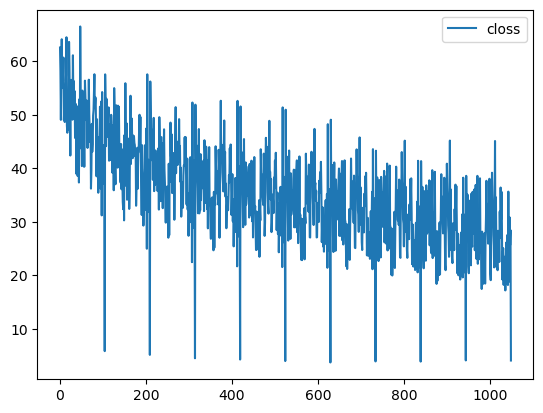

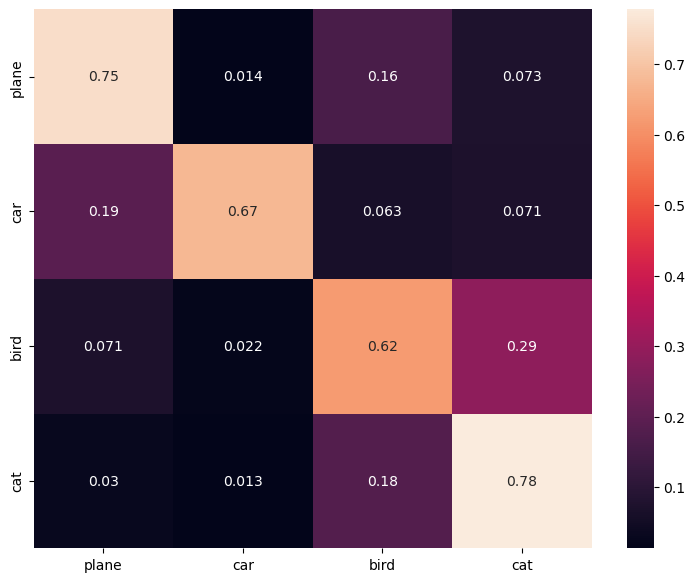

In [17]:
model = Net(n_cifar_class)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
pylon_train(model, 10, optimizer)
y_true, y_pred, _ = prim_test(model, cifar_test_loader)
plot_confusion_matrix(y_true, y_pred, prim_class_names)